# Reconnaissance d'images avec un CNN (PyTorch)

Ce notebook te guide **de A à Z** : imports, chargement des données, visualisation, création d'un **CNN simple**, entraînement, évaluation, et **vérification CUDA**.

> Dataset utilisé : **Fashion-MNIST** (10 classes, images 28×28 en niveaux de gris).  
> Avantages : rapide à entraîner, parfait pour un contrôle / compte rendu.


In [4]:
# ⬇️ (Optionnel) Installer les dépendances si besoin
# !pip install torch torchvision matplotlib --quiet

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Pour des résultats reproductibles
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

print("PyTorch version :", torch.__version__)


PyTorch version : 2.9.1+xpu


## 1) Vérification CUDA (GPU)

On vérifie si un GPU NVIDIA (CUDA) est disponible.  
Le notebook utilisera automatiquement **GPU si dispo**, sinon **CPU**.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA disponible ? ->", torch.cuda.is_available())
print("Appareil utilisé :", device)

if torch.cuda.is_available():
    print("Nom GPU :", torch.cuda.get_device_name(0))
    # Petit test de calcul sur GPU
    x = torch.randn(1000, 1000, device=device)
    y = x @ x
    print("Test GPU OK, y.shape =", y.shape)


CUDA disponible ? -> False
Appareil utilisé : cpu


## 2) Chargement et préparation des données

On applique des transformations :
- conversion en tenseur,
- normalisation (moyenne/écart-type) pour faciliter l'entraînement.


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # pour images en niveaux de gris
])

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

classes = dataset.classes  # noms des classes

# Option : split train/val
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print("Taille train :", len(train_dataset))
print("Taille val   :", len(val_dataset))
print("Taille test  :", len(test_dataset))


Taille train : 54000
Taille val   : 6000
Taille test  : 10000


## 3) Visualisation de quelques images

On affiche un mini-grid d'images avec leur label.


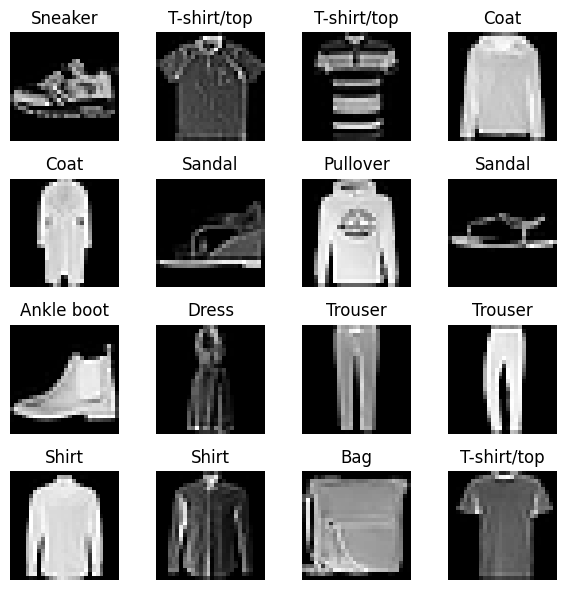

In [7]:
def denormalize(x):
    # inverse de Normalize((0.5,), (0.5,)) : x_norm = (x - 0.5)/0.5  => x = x_norm*0.5 + 0.5
    return x * 0.5 + 0.5

images, labels = next(iter(train_loader))
images = images[:16]
labels = labels[:16]

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = denormalize(images[i]).squeeze().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


## 4) Définition d'un CNN simple

Architecture (exemple) :
- Conv(1→16) + ReLU + MaxPool
- Conv(16→32) + ReLU + MaxPool
- Flatten
- Dense(32×7×7 → 128) + ReLU
- Dense(128 → 10)

Ce CNN est volontairement **simple** et robuste pour l'apprentissage.


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=len(classes)).to(device)
print(model)

# Nombre de paramètres
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Paramètres entraînables :", num_params)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Paramètres entraînables : 206922


## 5) Boucles d'entraînement et d'évaluation

- Fonction de perte : **CrossEntropyLoss** (classification multi-classes)
- Optimiseur : **Adam**
- Mesure : **accuracy** (précision)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        acc = accuracy_from_logits(logits, y)

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


## 6) Entraînement

Tu peux ajuster :
- `epochs` (ex: 3 à 10)
- `batch_size`
- `lr` (learning rate)

Sur GPU, ça va très vite. Sur CPU, ça reste OK.


In [10]:
epochs = 5
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{epochs} | "
          f"train loss={train_loss:.4f}, train acc={train_acc:.4f} | "
          f"val loss={val_loss:.4f}, val acc={val_acc:.4f}")


Epoch 1/5 | train loss=0.5738, train acc=0.7929 | val loss=0.3848, val acc=0.8618
Epoch 2/5 | train loss=0.3624, train acc=0.8689 | val loss=0.3161, val acc=0.8868
Epoch 3/5 | train loss=0.3137, train acc=0.8861 | val loss=0.2916, val acc=0.8920
Epoch 4/5 | train loss=0.2844, train acc=0.8971 | val loss=0.2825, val acc=0.8968
Epoch 5/5 | train loss=0.2659, train acc=0.9031 | val loss=0.2596, val acc=0.9036


## 7) Courbes de loss et accuracy

Un classique dans un compte rendu : montrer l'évolution pendant l'entraînement.


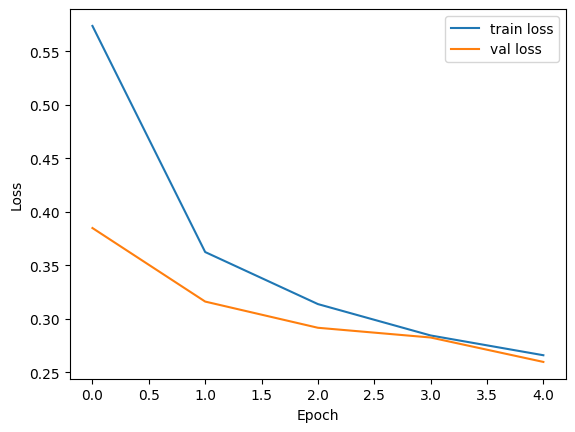

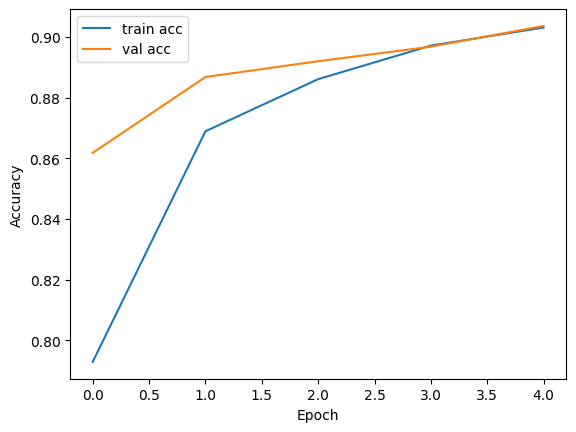

In [11]:
plt.figure()
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 8) Évaluation finale sur le jeu de test

C'est le score le plus "honnête" car le test n'a pas été vu pendant l'entraînement.


In [12]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test loss = {test_loss:.4f}")
print(f"Test accuracy = {test_acc:.4f}")


Test loss = 0.2767
Test accuracy = 0.8996


## 9) Quelques prédictions (qualitatif)

On affiche des images de test + la classe prédite + la vraie classe.


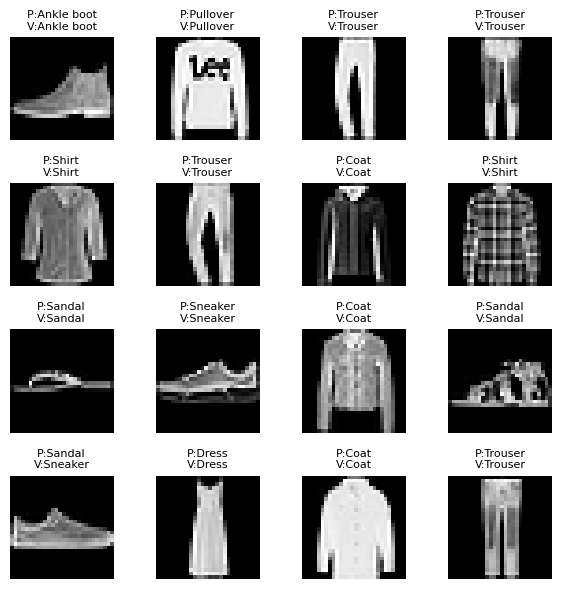

In [13]:
@torch.no_grad()
def show_predictions(model, loader, n=16):
    model.eval()
    x, y = next(iter(loader))
    x, y = x[:n].to(device), y[:n].to(device)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)

    x_cpu = denormalize(x.cpu())

    plt.figure(figsize=(6, 6))
    for i in range(n):
        plt.subplot(4, 4, i+1)
        img = x_cpu[i].squeeze().numpy()
        plt.imshow(img, cmap="gray")
        title = f"P:{classes[preds[i]]}\nV:{classes[y[i]]}"
        plt.title(title, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, n=16)

## 10) Sauvegarde / chargement du modèle (optionnel)

Utile si tu veux réutiliser le modèle entraîné sans tout recalculer.


In [14]:
# Sauvegarde
model_path = "simple_cnn_fashionmnist.pth"
torch.save(model.state_dict(), model_path)
print("Modèle sauvegardé ->", model_path)

# Chargement (exemple)
# model2 = SimpleCNN(num_classes=len(classes)).to(device)
# model2.load_state_dict(torch.load(model_path, map_location=device))
# model2.eval()


Modèle sauvegardé -> simple_cnn_fashionmnist.pth


## Mini-aide pour ton compte rendu

- **But** : classifier des images parmi 10 classes.
- **Pré-traitement** : ToTensor + Normalize.
- **Architecture** : 2 convolutions + pooling + 2 denses.
- **Loss** : CrossEntropy.
- **Optimiseur** : Adam.
- **Résultats** : accuracy test + courbes loss/acc.
- **CUDA** : testé automatiquement.

Tu peux copier/coller des captures des graphiques et des prédictions dans ton rapport.


## 8) Outils pour Expérimentation

Nous définissons ici les classes nécessaires (`FlexibleCNN`, `EarlyStopping`, `train_experiment`) directement dans le notebook pour plus de clarté.

In [15]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Flexible Model ---
class FlexibleCNN(nn.Module):
    def __init__(self, num_classes=10, kernel_size=3, use_pooling=True, input_channels=1, image_size=28):
        super(FlexibleCNN, self).__init__()
        self.use_pooling = use_pooling
        
        # Padding to maintain spatial dimensions approximately
        padding = kernel_size // 2 
        
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2) if use_pooling else nn.Identity()
        
        final_dim = image_size // 4 if use_pooling else image_size
        flat_size = 32 * final_dim * final_dim
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.classifier(x)
        return x

# --- Early Stopping ---
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# --- Training Experiment ---
def train_experiment(model, device, train_loader, val_loader, epochs=10, lr=1e-3, use_early_stopping=False, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=3) if use_early_stopping else None
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    if verbose:
        print(f"Training: Kernel={model.conv1.kernel_size[0]}x{model.conv1.kernel_size[0]}, Pooling={model.use_pooling}, EarlyStop={use_early_stopping}")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            
        train_loss = running_loss / total
        train_acc = correct / total
        
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_running_loss += loss.item() * x.size(0)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if verbose:
            print(f"Ep {epoch+1}: Train Loss={train_loss:.3f} Acc={train_acc:.3f} | Val Loss={val_loss:.3f} Acc={val_acc:.3f}")
        
        if use_early_stopping and early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                if verbose: print("--> Early stopping triggered!")
                break
                
    return history

# --- Visualization Utils ---
def plot_histories(histories):
    plt.figure(figsize=(14, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for name, hist in histories.items():
        plt.plot(hist['val_acc'], label=f"{name} Val Acc")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    for name, hist in histories.items():
        plt.plot(hist['val_loss'], label=f"{name} Val Loss")
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.show()

def show_full_metrics(model, loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


### Expérience 1: Comparaison Taille des Noyaux (3x3 vs 5x5)
On compare la performance de deux modèles identiques, variant seulement la taille du noyau de convolution.

Device: cpu
=== EXP 1: Kernel Size 3x3 vs 5x5 ===


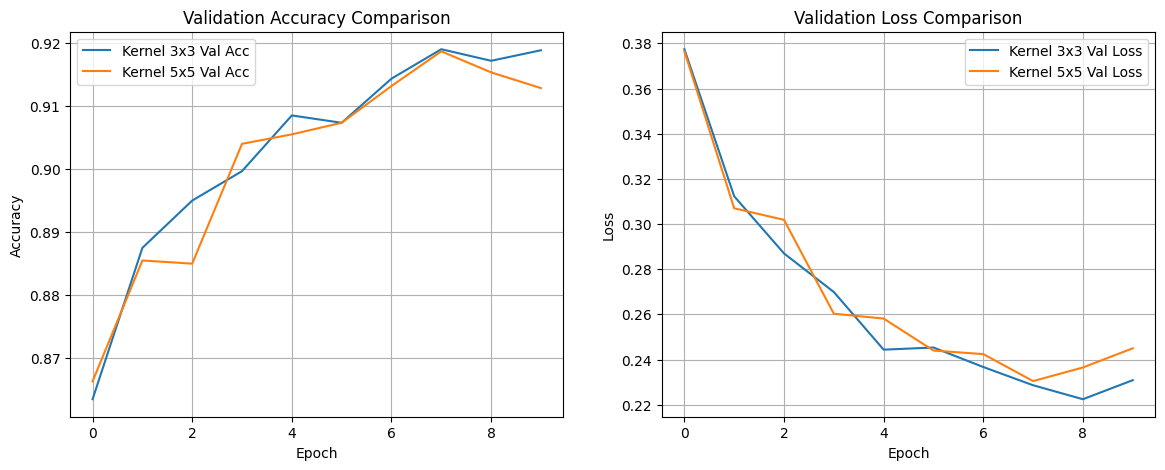

In [16]:
# Verification device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("=== EXP 1: Kernel Size 3x3 vs 5x5 ===")
model_k3 = FlexibleCNN(num_classes=10, kernel_size=3, use_pooling=True).to(device)
model_k5 = FlexibleCNN(num_classes=10, kernel_size=5, use_pooling=True).to(device)

hist_k3 = train_experiment(model_k3, device, train_loader, val_loader, epochs=10, verbose=False)
hist_k5 = train_experiment(model_k5, device, train_loader, val_loader, epochs=10, verbose=False)

plot_histories({"Kernel 3x3": hist_k3, "Kernel 5x5": hist_k5})

### Expérience 2: Pooling vs Sans Pooling
On observe l'effet du MaxPooling sur la performance et la convergence.

=== EXP 2: Pooling vs No Pooling ===


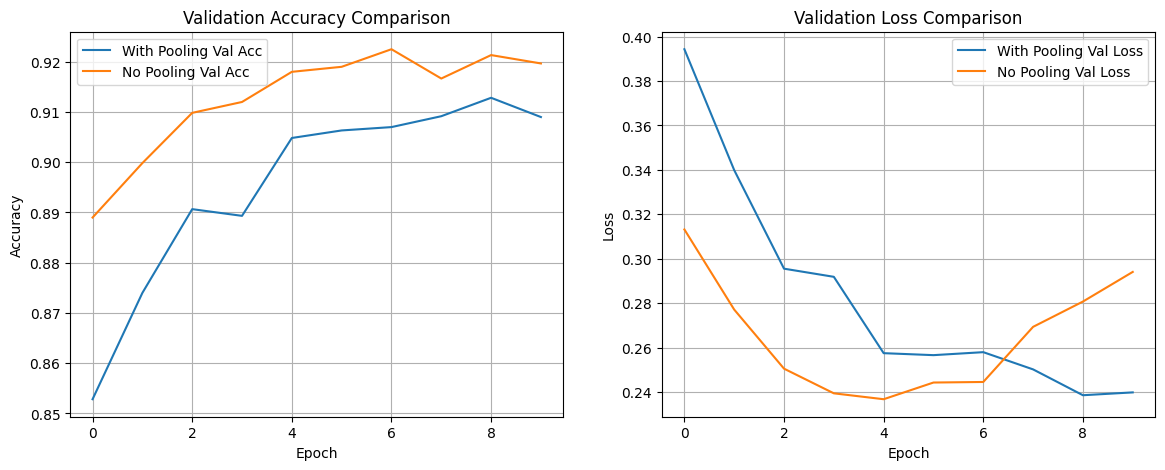

In [17]:
print("=== EXP 2: Pooling vs No Pooling ===")
model_pool = FlexibleCNN(num_classes=10, kernel_size=3, use_pooling=True).to(device)
model_nopool = FlexibleCNN(num_classes=10, kernel_size=3, use_pooling=False).to(device)

hist_pool = train_experiment(model_pool, device, train_loader, val_loader, epochs=10, verbose=False)
hist_nopool = train_experiment(model_nopool, device, train_loader, val_loader, epochs=10, verbose=False)

plot_histories({"With Pooling": hist_pool, "No Pooling": hist_nopool})

### Expérience 3: Early Stopping & Métriques Complètes
On entraîne un modèle avec un arrêt précoce pour éviter le sur-apprentissage, et on affiche la matrice de confusion.

=== EXP 3: Early Stopping ===
Training: Kernel=3x3, Pooling=True, EarlyStop=True
Ep 1: Train Loss=0.561 Acc=0.799 | Val Loss=0.380 Acc=0.864
Ep 2: Train Loss=0.355 Acc=0.870 | Val Loss=0.315 Acc=0.883
Ep 3: Train Loss=0.303 Acc=0.889 | Val Loss=0.284 Acc=0.893
Ep 4: Train Loss=0.273 Acc=0.899 | Val Loss=0.265 Acc=0.899
Ep 5: Train Loss=0.251 Acc=0.908 | Val Loss=0.247 Acc=0.909
Ep 6: Train Loss=0.233 Acc=0.914 | Val Loss=0.239 Acc=0.906
Ep 7: Train Loss=0.219 Acc=0.919 | Val Loss=0.242 Acc=0.908
Ep 8: Train Loss=0.205 Acc=0.923 | Val Loss=0.235 Acc=0.910
Ep 9: Train Loss=0.192 Acc=0.929 | Val Loss=0.230 Acc=0.914
Ep 10: Train Loss=0.179 Acc=0.934 | Val Loss=0.238 Acc=0.911
Ep 11: Train Loss=0.171 Acc=0.935 | Val Loss=0.234 Acc=0.918
Ep 12: Train Loss=0.157 Acc=0.942 | Val Loss=0.233 Acc=0.918
--> Early stopping triggered!
Affichage des métriques complètes sur le jeu de test:

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.84

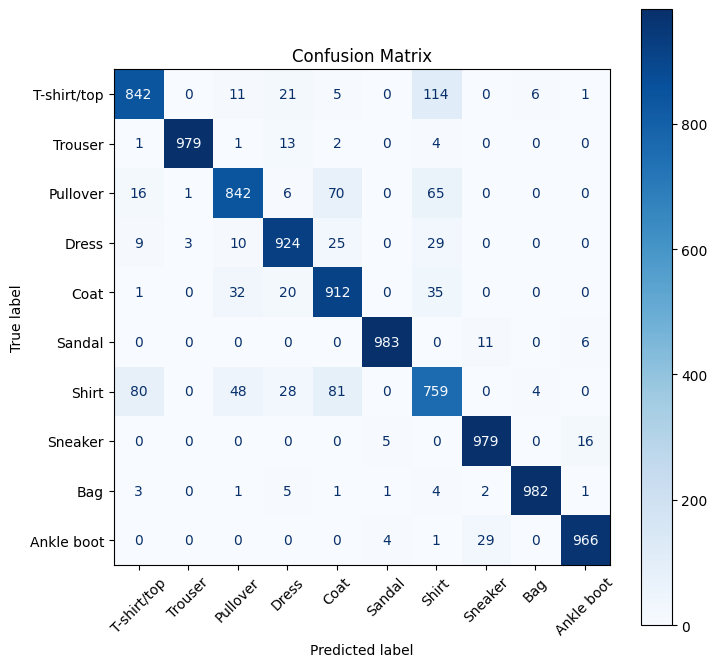

In [18]:
print("=== EXP 3: Early Stopping ===")
model_es = FlexibleCNN(num_classes=10, kernel_size=3, use_pooling=True).to(device)
hist_es = train_experiment(model_es, device, train_loader, val_loader, epochs=20, use_early_stopping=True)

print("Affichage des métriques complètes sur le jeu de test:")
show_full_metrics(model_es, test_loader, device, classes)